# Lab 10 - Principal Component Analysis

The purpose of the following lab is to investigate the work of the PCA algorithm on a set of 3 datasets
- Sample of 2500 data-points drawn from a multivariate Gaussian with a diagonal covariance matrix with different variances.
- Sample of 1000 data-points sampled on the $\ell_2$ unit circle and then randomly rotated in $\mathbb{R}^3$
- A simple real-world dataset of arrests in the United States.


In [1]:
import sys 
sys.path.append("../")
from utils import *

In [2]:
from scipy.stats import ortho_group
from sklearn.decomposition import PCA
np.random.seed(1)

color_scheme = ["rgb(189,6,96)", "rgb(6,189,99)", "rgb(6,96,189)"]

def plot_principal_component(pca, i):
    # Get PC representation as a subspace with size proportional to the corresponding singular value
    size = np.sqrt(pca.singular_values_[i])
    pc = np.outer(pca.components_[i], np.array([-1,1])) * size

    return go.Scatter3d(x=pc[0], y=pc[1], z=pc[2], mode="lines", opacity=.5,
                        line=dict(color=color_scheme[i], width=2*size), name='PC {}'.format(i+1))


Run one of the code cells below to load the desired dataset and relevant settings.

In [11]:
# Multivariate Gaussian
cov = [3, 0, 0], [0, 1, 0], [0, 0, 0.1]
X = np.random.multivariate_normal([0, 0, 0], cov, size=2500) @ ortho_group.rvs(3, random_state=1)
scene = proj_scene = dict(xaxis=dict(range=[-4, 4]), yaxis=dict(range=[-4, 4]), zaxis=dict(range=[-4, 4]), 
             camera=dict(eye=dict(x=1.5, y=1.5, z=.5)))

In [4]:
# Circular data
X = np.random.normal(size=(2, 1000))
X = np.c_[(X/ np.linalg.norm(X, axis=0)).T, np.random.normal(0, .1, 1000)]
X = X @ ortho_group.rvs(3, random_state=1)
scene = proj_scene = dict(xaxis=dict(range=[-1.5, 1.5]), yaxis=dict(range=[-1.5, 1.5]), zaxis=dict(range=[-1.5, 1.5]), 
             camera=dict(eye=dict(x=-1.5, y=-1.5, z=.1)))

In [15]:
# Real-world data: US Arrests
X = pd.read_csv("../datasets/USArrests.data", index_col=0).drop("UrbanPop", axis=1).to_numpy()
X = (X - X.mean(axis=0))
scene = dict(xaxis=dict(range=[-10,10]), yaxis=dict(range=[-130,170]), zaxis=dict(range=[-20,30]), 
             camera=dict(eye=dict(x=2, y=-2, z=.4)))
proj_scene = dict(xaxis=dict(range=[-130,170]), yaxis=dict(range=[-20,20]), zaxis=dict(range=[-5,10]), 
             camera=dict(eye=dict(x=2, y=-2, z=.4)))

## Projection Using PCA
Let us begin with visualizing the original dataset as well as the PC components determined by the algorithm. In Figure 1, we can see the spread of the dataset in $\mathbb{R}^3$, and that though it is represented in a 3 dimensional space, it is mostly described along some 2 dimensional space. 

Looking at the PCs, and specifically at their size and width, we get an understandment of "how much" of the data is spread in each direction.

Rotate Figure 1 to view the data in two ways. Firstly view the data in an angle perpendicular to both PC1 and PC2. This will be the angle that the data has the largest amount of spread in a 2 dimensional subspace. See how for both the Gaussian and Circular datasets we are still able to see the main trends of the data. Next, view the data in an angle perpendicular to PC3. In this direction of the 3 dimentional space we are not able to get a clear view of the main trends of the data. We merly observe a dense cloud of points.

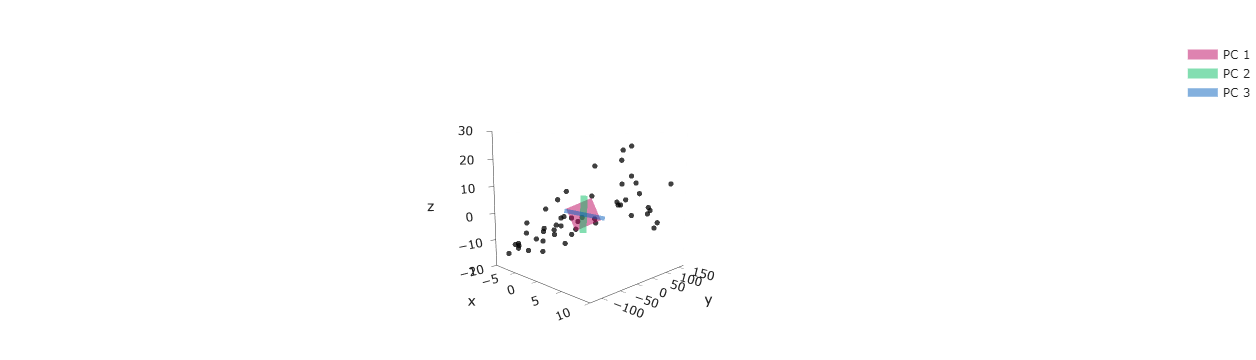

In [16]:
pca = PCA(n_components=3).fit(X)

go.Figure(data = [go.Scatter3d(x = X[:, 0], y=X[:, 1], z=X[:, 2], opacity = .75, mode = 'markers', 
                               marker=dict(size=3, color="black"), showlegend=False)] + 
                 [plot_principal_component(pca, i) for i in range(3)],
          layout = go.Layout(title=r"$\text{(1) Original Dataset with PC Components}$", 
                             scene = scene, scene_aspectmode="cube"))  

Now that we understand how is the data spread across the three computed PCs, let us project it onto them (Figure 2). To do so let $U\in\mathbb{R}^{d\times k}$ be the matrix with the PCs as columns. As we are currently projecting using all 3 PCs then $U$ is a $3$-by-$3$ orthonormal matrix.

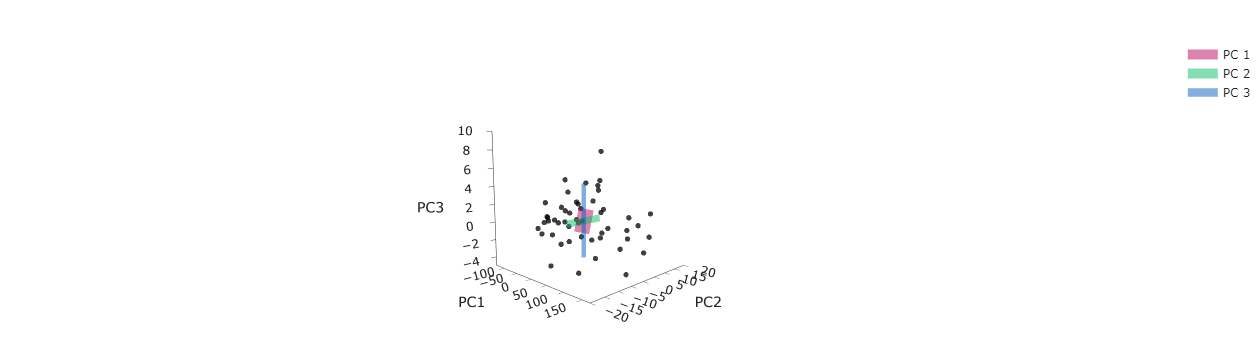

In [17]:
from copy import deepcopy
tmp = deepcopy(pca)
tmp.components_ = np.array(pca.transform(pca.components_)).T

X_projected = pca.transform(X)
go.Figure(data = [go.Scatter3d(x = X_projected[:, 0], y=X_projected[:, 1], z=X_projected[:, 2], opacity = 0.75, 
                               mode = 'markers', marker=dict(size=3, color="black"), showlegend=False)] + 
                 [plot_principal_component(tmp, i) for i in range(3)],
          layout = go.Layout(scene=proj_scene, scene_aspectmode="cube",
                             title=r"$\text{(2) Projection Onto PCA Subspace}$",
                             scene_xaxis_title="PC1",
                             scene_yaxis_title="PC2",
                             scene_zaxis_title="PC3"))

## Projection Onto PCA Subspace Of Lower Dimension

So we have seen that the PCA algorithm provides us with an orthonormal basis, with a desired properly that the directions correspond with the amount of spread the data shows in that direction.

Recall that as the algorithm provided an orthonormal basis then we can represent each sample $\mathbf{x}_i$ as a linear composition of the columns of $U$: $$ \mathbf{x}_i = \sum^d_{j=1} \langle\mathbf{x}_i,\mathbf{u}_j\rangle \mathbf{u}_j $$

When we project onto the $k<d$ subspace the summation is only using the first $k$ eigenvectors. In matrix notation we compute $\widetilde{\mathbf{X}} = U^\top\left(\mathbf{X}U\right)$ where $U\in\mathbb{R}^{d\times k}$.

*For deductive reasons in the code below we take the transformed (projected) data, zero the last dimensions and then perform the multiplication by $U$ using the `inverse_transform` function*.

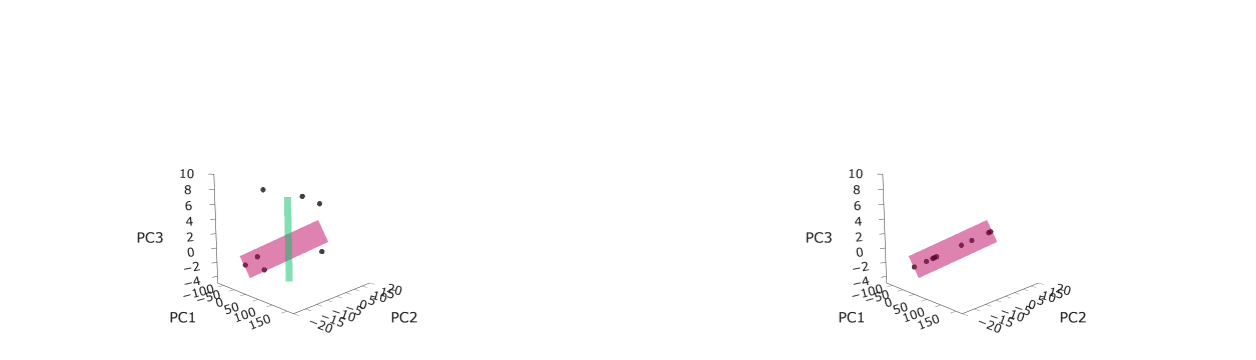

In [8]:
# Embedding in a 2D subspace
X2d = X_projected.copy()
X2d[:, 2] = 0
X2d = pca.inverse_transform(X2d)

# Enbedding in a 1D subspace
X1d = X_projected.copy()
X1d[:, [1,2]] = 0
X1d = pca.inverse_transform(X1d)


fig = make_subplots(rows=1, cols=2, subplot_titles=[r"$\text{2D Projection}$", r"$\text{1D Projection}$"],
                    specs=[[{"type":"scatter3d"}, {"type":"scatter3d"}]])

fig.add_traces([go.Scatter3d(x = X2d[:, 0], y=X2d[:, 1], z=X2d[:, 2], opacity = 0.75, mode = 'markers', marker=dict(size=3, color="black")),
                plot_principal_component(pca, 0),
                plot_principal_component(pca, 1)], rows=1, cols=1)
fig.add_traces([go.Scatter3d(x = X1d[:, 0], y=X1d[:, 1], z=X1d[:, 2], opacity = 0.75, mode = 'markers', marker=dict(size=3, color="black")),
                plot_principal_component(pca, 0)], rows=1, cols=2)

fig.update_layout(title=r"$\text{(3) Projection Onto Lower Dimension Subspace}$", margin = dict(t = 100), showlegend=False,
                  scene=proj_scene, scene2=proj_scene, scene_aspectmode="cube",
                  scene_xaxis_title="PC1", scene2_xaxis_title="PC1",
                  scene_yaxis_title="PC2", scene2_yaxis_title="PC2",
                  scene_zaxis_title="PC3", scene2_zaxis_title="PC3")
fig.show()

## Explained Variance and Singular Values

In the parts above, we have linked between the different PCs and how much does the data "spread" in each PC direction. This spread is the variance (as in variance of random variables) of the data in the current direction.

We have seen that the subspace found by the PCA algorithm is the subspace of some degree $k$ that retains the maximum variance out of all $k$ dimensional subspace. In the proof itself the link between the variance, the principal components and the singular values becomes evident: If we search for a vector onto which we orthogonally project the data and that this vector maximizes the variance of the projected data then:
 - This vector, which we name as a principal component, is an eigenvector of the sample covariance matrix.
 - The variance retained by the projection is proportional to the corresponding eigenvalue.
 - To find the direction with maximum variance we take the first PC to be the eigenvector with the largest eigenvalue.

Then, for the next PC we search for a direction in space, satisfying the above but also is perpendicular to the first PC. We continue until we find $k$ PCs.

Here, we shall explore this link in an empirical manner, over the loaded datasets. First, let us compute the explained variance. That is, the proportion of variance spread across each PC. As this variance is proportional to the eigenvalues of the sample covariance matrix (which are the singular values of the original data matrix squared) then:

In [18]:
from pandas import DataFrame

pca = PCA(n_components=3).fit(X)

ev = pca.singular_values_**2
DataFrame(np.array([ev, ev/sum(ev), pca.explained_variance_ratio_]),
          columns=["PC 1", "PC 2", "PC3"],
          index=["Eigenvalues", "Explained Variance", "sklearn's Explained Variance"])

,PC 1,PC 2,PC3
Eigenvalues,342827.556138,2384.273326,329.572136
Explained Variance,0.992146,0.006900,0.000954
sklearn's Explained Variance,0.992146,0.006900,0.000954


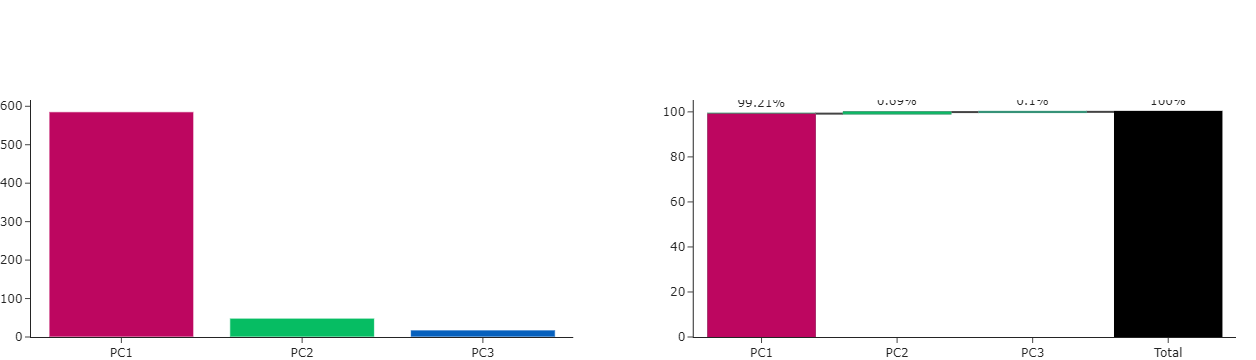

In [10]:
variance = list(np.around(100*pca.explained_variance_ratio_, 2)) + [100]

fig = make_subplots(rows=1, cols=2, subplot_titles=[r"$\text{Eigenvalues}$", r"$\text{Cumulative Explained Variance}$"],
                    specs=[[{'type': 'Bar'}, {'type': 'Waterfall'}]])

fig.add_traces([go.Bar(x=['PC1', 'PC2', 'PC3'], y=pca.singular_values_, marker_color = color_scheme),
                go.Waterfall(x=["PC1", "PC2", "PC3", "Total"],
                             y=variance,
                             text=[f"{v}%" for v in variance],
                             textposition = "outside",
                             totals = {"marker":{"color":"black"}},
                             measure = ["relative", "relative", "relative", "total"])],
               rows=[1,1], cols=[1,2])

fig.add_shape(type="rect", xref="x", yref="y", x0=-0.4, x1=0.4, y0=0.0, y1=fig.data[1].y[0], 
              fillcolor=color_scheme[0], line=dict(color=color_scheme[0]), opacity=1,row=1, col=2)
fig.add_shape(type="rect", xref="x", yref="y", x0=0.6, x1=1.4, y0=fig.data[1].y[0], y1=fig.data[1].y[0]+fig.data[1].y[1],
              fillcolor=color_scheme[1], line=dict(color=color_scheme[1]), opacity=1, row=1, col=2)
fig.add_shape(type="rect", xref="x", yref="y", x0=1.6, x1=2.4, y0=fig.data[1].y[0]+fig.data[1].y[1], y1=fig.data[1].y[0]+fig.data[1].y[1]+fig.data[1].y[2], 
              fillcolor=color_scheme[2], line=dict(color=color_scheme[2]), opacity=1, row=1, col=2)

fig.update_layout(showlegend=False, title=r"$\text{(4) PCA Explained Variance}$", margin=dict(t=100))
fig.show()

# Time To Think...
After investigative both simulated datasets with a variety of settings let us focus on the real-world dataset. 

Consider figures 1,2 and 4 and think:
- Looking at Figure 1, can we imagine some low dimension subspace that fits the data? What would be the dimension of such a subspace? 
- Does the representation of the data in the PCs basis in Figure 2 support or contradict your answer regarding Figure 1? (Pay attention to the scales of the PC axes. To make things clearer you are encouraged to change the `proj_scene` variable relevant to this dataset.)
- How does the explained variance relate to the conclusions above? Based on Figure 4, what would you choose as the dimension of the embedded subspace? Is this in agreement with your previous answers?

Lastly, using this real-world example but considering PCA as a general algorithm: in terms of model interperability, do the PCs help us infer anything regarding the original features? For example, suppose 90% of the explained variance is captured by the first PC, does it tell us how significant was the first feature? Does it tell us how significant any individual feature is? How would we be able to interprate relevance of features based on the projection or coordinates given by the PCA algorithm?